# Neural Network Classification in Pytorch

## Neural Network Architecture
Generally speaking a neural network will have the following hyperparameters
- Input Layer
- Hidden Layers
- Neurons per layer
- Output Layer shape (varies depending on number of classes in classification problem)
- Hidden Layer Activation
- Output Layer Activation
- Loss function
- Optimizer

Let's start by getting some data

In [46]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
X, y = make_circles(n_samples=1000, noise=0.1, random_state=42)
print(X[:5])
print(y[:5])

[[ 0.71210844  0.28469831]
 [-0.67871584  0.20727355]
 [-0.86602567  0.34365139]
 [-0.51764775  0.62059874]
 [ 0.4540887  -0.89046586]]
[1 1 1 1 0]


LEt's put our dataset into a pandas dataframe

In [47]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.712108,0.284698,1
1,-0.678716,0.207274,1
2,-0.866026,0.343651,1
3,-0.517648,0.620599,1
4,0.454089,-0.890466,0
5,-0.445483,0.787044,1
6,-0.022038,0.811310,1
7,0.729897,0.188943,1
8,-0.191616,-0.815790,1
9,-0.083442,1.093954,0


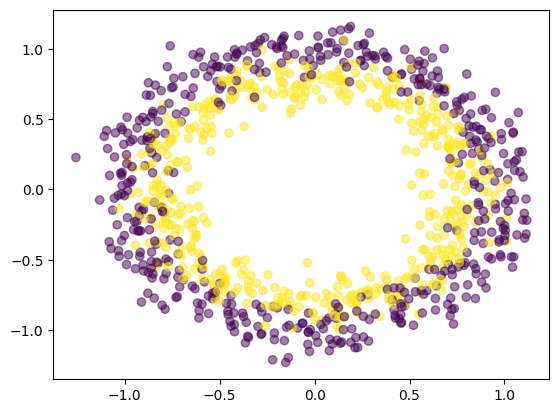

In [48]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1],c=y,alpha=0.5)

Let' try to build a neural network to classify 

In [49]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

In [50]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

split our data for cross validation

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, random_state=42)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

Now our data is ready let's start building our model

In [52]:
class CircleModel_v0(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        #construct a 2-layer neural network that splits our input into 5 neurons, then 1 neuron
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(2,5)
        self.layer_2 = nn.Linear(5,1)
    
    def forward(self, x):
        #feed the input through the layers, no activation function for now
        return self.layer_2(self.layer_1(x))
model_v0 = CircleModel_v0().to(device)

In [53]:
untrained_pred = model_v0(X_test.to(device))
#make sure the length of the prediction is the same as the length of the test set
len(untrained_pred) == len(y_test)

True

Now let's declare an optimizer and a loss function so we can train our neural net

In [60]:
from torch.optim import SGD
from torch.nn import BCEWithLogitsLoss
#instantiate the loss function
loss_function = BCEWithLogitsLoss()
#instantiate the optimizer
optimizer = SGD(model_v0.parameters(), lr=0.1)
#define an accuracy metric
def accuracy_fn(y_pred,y_true):
    correct = torch.eq(y_pred,y_true).sum()
    accuracy = correct.float() / len(y_true) * 100
    return accuracy

Now let's write a training loop

In [64]:

epochs = 100
loss_vals = []
accuracy = []

#set the model to train mode
model_v0.train()
for epoch in range(epochs):
    #calculate the prediction
    pred = model_v0(X_train).squeeze()
    pred_labels = torch.round(torch.sigmoid(pred))
    #calculate the loss
    loss = loss_function(pred,y_train)
    #zero the gradients
    optimizer.zero_grad()
    #backpropagate
    loss.backward()
    #update the parameters
    optimizer.step()
    #calculate the accuracy
    acc = accuracy_fn(pred_labels,y_train)
    loss_vals.append(loss)
    accuracy.append(acc)
    with torch.inference_mode():
        model_v0.eval()
        test_pred = model_v0(X_test).squeeze()
        test_loss = loss_function(test_pred,y_test)
        test_acc = accuracy_fn(torch.round(torch.sigmoid(test_pred)),y_test)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} Training Loss: {loss} Training Accuracy: {acc} Test Loss: {test_loss} Test Accuracy: {test_acc}")

Epoch 0 Training Loss: 0.7364519834518433 Training Accuracy: 53.249996185302734 Test Loss: 0.7429710030555725 Test Accuracy: 52.0
Epoch 10 Training Loss: 0.7167065143585205 Training Accuracy: 52.0 Test Loss: 0.7234031558036804 Test Accuracy: 52.0
Epoch 20 Training Loss: 0.7079980373382568 Training Accuracy: 51.625 Test Loss: 0.7144514918327332 Test Accuracy: 50.0
Epoch 30 Training Loss: 0.7034188508987427 Training Accuracy: 51.625 Test Loss: 0.7095828056335449 Test Accuracy: 51.0
Epoch 40 Training Loss: 0.7006390690803528 Training Accuracy: 51.625 Test Loss: 0.7065349221229553 Test Accuracy: 49.499996185302734
Epoch 50 Training Loss: 0.6987786889076233 Training Accuracy: 51.375 Test Loss: 0.7044316530227661 Test Accuracy: 50.0
Epoch 60 Training Loss: 0.697456955909729 Training Accuracy: 51.375 Test Loss: 0.7028866410255432 Test Accuracy: 50.5
Epoch 70 Training Loss: 0.6964837312698364 Training Accuracy: 51.875 Test Loss: 0.7017049193382263 Test Accuracy: 50.0
Epoch 80 Training Loss: 0.

This is not going well, let's see why

In [67]:
#Download some pytorch helper functions
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists


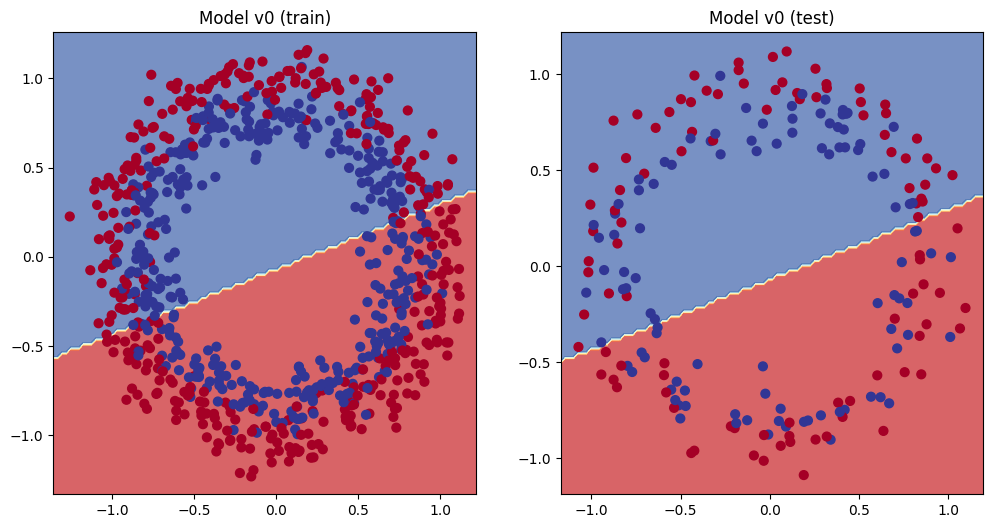

In [69]:
from helper_functions import plot_predictions,plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Model v0 (train)")
plot_decision_boundary(model_v0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Model v0 (test)")
plot_decision_boundary(model_v0,X_test,y_test)


Since we only have 1 hidden layer our neural net is creating a linear estimation of circular data. That's not going to work, so let's add more hidden layers